850 hPa Temperature Advection
=============================

Plot an 850 hPa map with calculating advection using MetPy.

Beyond just plotting 850-hPa level data, this uses calculations from `metpy.calc` to find
the temperature advection. Currently, this needs an extra helper function to calculate
the distance between lat/lon grid points.

Imports

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import scipy.ndimage as ndimage

from cftime import num2pydate
from metpy.units import units
from siphon.catalog import TDSCatalog

Helper functions

In [2]:
# Helper function for finding proper time variable
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)

Create NCSS object to access the NetcdfSubset
---------------------------------------------
Data from NCEI GFS 0.5 deg Analysis Archive

In [3]:
dt = datetime(2017, 4, 5, 12)

# Assemble our URL to the THREDDS Data Server catalog,
# and access our desired dataset within via NCSS
base_url = 'https://www.ncei.noaa.gov/thredds/model-gfs-g4-anl-files-old/'
cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')
ncss = cat.datasets[f'gfsanl_4_{dt:%Y%m%d}_{dt:%H}00_000.grb2'].subset()

# Create NCSS query for our desired time, region, and data variables
query = ncss.query()

query.time(dt)
query.lonlat_box(north=65, south=15, east=310, west=220)
query.accept('netcdf')
query.variables('Geopotential_height_isobaric',
                'Temperature_isobaric',
                'u-component_of_wind_isobaric',
                'v-component_of_wind_isobaric')

# Obtain the queried data
data = ncss.get_data(query)

# Pull out variables you want to use
hght_var = data.variables['Geopotential_height_isobaric']
temp_var = data.variables['Temperature_isobaric']
u_wind_var = data.variables['u-component_of_wind_isobaric']
v_wind_var = data.variables['v-component_of_wind_isobaric']
time_var = data.variables[find_time_var(temp_var)]
lat_var = data.variables['lat']
lon_var = data.variables['lon']

# Get actual data values and remove any size 1 dimensions
lat = lat_var[:].squeeze()
lon = lon_var[:].squeeze()
hght = hght_var[:].squeeze()
temp = units.Quantity(temp_var[:].squeeze(), temp_var.units)
u_wind = units.Quantity(u_wind_var[:].squeeze(), u_wind_var.units)
v_wind = units.Quantity(v_wind_var[:].squeeze(), v_wind_var.units)

# Convert number of hours since the reference time into an actual date
time = num2pydate(time_var[:].squeeze(), time_var.units)

lev_850 = np.where(data.variables['isobaric'][:] == 850*100)[0][0]
hght_850 = hght[lev_850]
temp_850 = temp[lev_850]
u_wind_850 = u_wind[lev_850]
v_wind_850 = v_wind[lev_850]

# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Gridshift for barbs
lon_2d[lon_2d > 180] = lon_2d[lon_2d > 180] - 360

Begin data calculations
-----------------------

In [4]:
# Use helper function defined above to calculate distance
# between lat/lon grid points
dx, dy = mpcalc.lat_lon_grid_deltas(lon_var, lat_var)

# Calculate temperature advection using metpy function
adv = mpcalc.advection(temp_850, [u_wind_850, v_wind_850],
                       (dx, dy), dim_order='yx')

# Smooth heights and advection a little
# Be sure to only put in a 2D lat/lon or Y/X array for smoothing
Z_850 = mpcalc.smooth_gaussian(hght_850, 2)
adv = mpcalc.smooth_gaussian(adv, 2)

Begin map creation
------------------

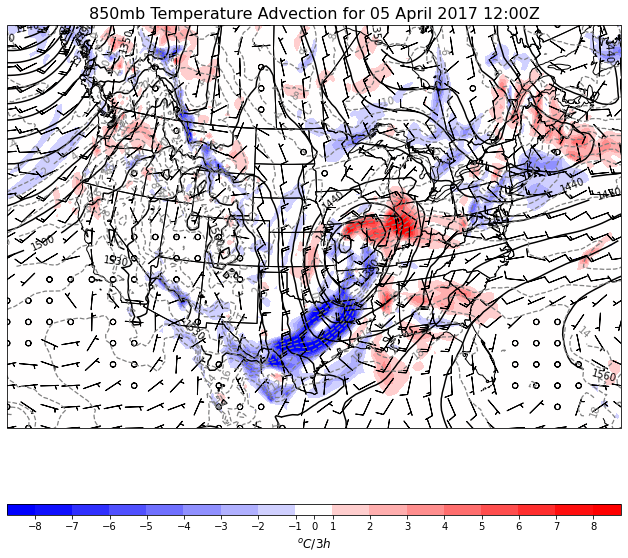

In [5]:
# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.LambertConformal(central_latitude=[30, 60], central_longitude=-100)

# Create new figure
fig = plt.figure(figsize=(11, 8.5))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02], bottom=.07, top=.99,
                       hspace=0.01, wspace=0.01)

# Add the map and set the extent
ax = plt.subplot(gs[0], projection=plotcrs)
plt.title(f'850mb Temperature Advection for {time:%d %B %Y %H:%MZ}', fontsize=16)
ax.set_extent([235., 290., 20., 55.])

# Add state/country boundaries to plot
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS)

# Plot Height Contours
clev850 = np.arange(900, 3000, 30)
cs = ax.contour(lon_2d, lat_2d, Z_850, clev850, colors='black', linewidths=1.5,
                linestyles='solid', transform=datacrs)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Temperature Contours
clevtemp850 = np.arange(-20, 20, 2)
cs2 = ax.contour(lon_2d, lat_2d, temp_850.to(units('degC')), clevtemp850,
                 colors='grey', linewidths=1.25, linestyles='dashed',
                 transform=datacrs)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Plot Colorfill of Temperature Advection
cint = np.arange(-8, 9)
cf = ax.contourf(lon_2d, lat_2d, 3*adv.to(units('delta_degC/hour')), cint[cint != 0],
                 extend='both', cmap='bwr', transform=datacrs)
cax = plt.subplot(gs[1])
cb = plt.colorbar(cf, cax=cax, orientation='horizontal', extendrect=True, ticks=cint)
cb.set_label(r'$^{o}C/3h$', size='large')

# Plot Wind Barbs
ax.barbs(lon_2d, lat_2d, u_wind_850.magnitude, v_wind_850.magnitude,
         length=6, regrid_shape=20, pivot='middle', transform=datacrs)